# 1. Dependencies

In [1]:
data_path = '../../dataset/'

import os
import sys
sys.path.insert(0, os.path.abspath('{}full_ibc'.format(data_path)))
import copy
import pickle
import numpy
import json
import random
from random import randint
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import nltk
from nltk.lm import Vocabulary
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('english'))
from nltk.corpus import wordnet as wn
nltk.download('wordnet')

from sklearn.tree import DecisionTreeClassifier as DCT
from sklearn.neighbors import KNeighborsClassifier

import fasttext

import seaborn

cuda


[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

# 2. Data loader

In [2]:
def generate_ibc_data():
    [lib, con, neutral] = pickle.load(open('{}full_ibc/ibcData.pkl'.format(data_path), 'rb'))

    tokenizer = nltk.RegexpTokenizer(r"\w+")
    ibc_lib = [([token for token in tokenizer.tokenize(tree.get_words().lower()) if token not in stopwords.words('english')], "LIBERAL")
               for tree in lib]
    ibc_con = [([token for token in tokenizer.tokenize(tree.get_words().lower()) if token not in stopwords.words('english')], "CONSERVATIVE")
               for tree in con]
    ibc_full_data = ibc_lib + ibc_con

    ibc_lib_size = len(ibc_lib)
    ibc_lib_train_size = int(ibc_lib_size*0.8)
    ibc_lib_val_size = int(ibc_lib_size*0.1)
    ibc_lib_test_size = ibc_lib_size - ibc_lib_train_size - ibc_lib_val_size
    ibc_lib_train_data, ibc_lib_val_data, ibc_lib_test_data = torch.utils.data.random_split(ibc_lib, [ibc_lib_train_size, ibc_lib_val_size, ibc_lib_test_size])
    
    ibc_con_size = len(ibc_con)
    ibc_con_train_size = int(ibc_con_size*0.8)
    ibc_con_val_size = int(ibc_con_size*0.1)
    ibc_con_test_size = ibc_con_size - ibc_con_train_size - ibc_con_val_size
    ibc_con_train_data, ibc_con_val_data, ibc_con_test_data = torch.utils.data.random_split(ibc_con, [ibc_con_train_size, ibc_con_val_size, ibc_con_test_size])

    ibc_train_data = ibc_lib_train_data + ibc_con_train_data
    ibc_val_data = ibc_lib_val_data + ibc_con_val_data
    ibc_test_data = ibc_lib_test_data + ibc_con_test_data
    ibc_labels = {"LIBERAL": 0, "CONSERVATIVE": 1}
    
    print('training data size:', len(ibc_train_data))
    print('validation data size:', len(ibc_val_data))
    print('test data size:', len(ibc_test_data))
    
    return ibc_train_data, ibc_val_data, ibc_test_data

def generate_data_loader(train_data, val_data, test_data, make_feature, make_target, labels={"LIBERAL": 0, "CONSERVATIVE": 1}, batch_size=1, cutoff=1):
    train_corpus = []
    for sentence, _ in train_data:
        train_corpus += sentence
    vocab_nltk = Vocabulary(train_corpus)
    
    vocab = {'<unknown>': 0}
    for word, count in vocab_nltk.counts.items():
        if count >= cutoff:
            vocab[word] = len(vocab)
            
    train_data_loader = torch.utils.data.DataLoader([(make_feature(sentence, vocab), make_target(label, labels)) for sentence, label in train_data],
                                                    batch_size=batch_size,
                                                    shuffle=True)
    val_data_loader = torch.utils.data.DataLoader([(make_feature(sentence, vocab), make_target(label, labels)) for sentence, label in val_data],
                                                  batch_size=batch_size)
    test_data_loader = torch.utils.data.DataLoader([(make_feature(sentence, vocab), make_target(label, labels)) for sentence, label in test_data],
                                                   batch_size=batch_size)
    return vocab, train_data_loader, val_data_loader, test_data_loader

In [3]:
torch.manual_seed(0)
ibc_train_data, ibc_val_data, ibc_test_data = generate_ibc_data()

training data size: 2980
validation data size: 372
test data size: 374


# 3 Ensemble method

## 3.1 Logistic regression

In [57]:
def make_bow_vec_lr(sentence, vocab):
    vec = torch.zeros(len(vocab), device=device)
    for word in sentence:
        if word in vocab:
            vec[vocab[word]] += 1
        else:
            vec[0] += 1
    return vec.view(-1)

def make_label_lr(label, label_to_id):
    return torch.tensor(label_to_id[label]).to(device)

In [58]:
class BoWClassifier(nn.Module):
    def __init__(self, vocab, output_size):
        super(BoWClassifier, self).__init__()
        self.vocab = vocab
        self.input_size = len(vocab)
        self.output_size = output_size
        self.linear = nn.Linear(self.input_size, self.output_size).to(device)
        
    def forward(self, bow_vec):
        return F.log_softmax(self.linear(bow_vec), dim=-1)
    
def lr_train(model, train_data, val_data, num_epochs=50):
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        for bow_vec, target in train_data:
            model.zero_grad()

            probs = model(bow_vec)
            loss = loss_function(probs, target)
            loss.backward()
            optimizer.step()
            
        if (epoch+1) % 10 == 0:
            print('{}: {}'.format(epoch+1, lr_eval(model, val_data)))
    
def lr_eval(model, data):
    model.eval()
    num_predictions = 0
    num_correct = 0
    with torch.no_grad():
        for bow_vec, target in data:
            probs = model(bow_vec)
            for i in range(len(probs)):
                num_predictions += 1
                if (torch.argmax(probs[i]) == target[i]):
                    num_correct += 1
    model.train()
    return num_correct/num_predictions*100

In [146]:
ibc_vocab, ibc_train_data_loader, ibc_val_data_loader, ibc_test_data_loader = generate_data_loader(ibc_train_data,
                                                                                                   ibc_val_data,
                                                                                                   ibc_test_data,
                                                                                                   make_bow_vec_lr,
                                                                                                   make_label_lr,
                                                                                                   {"LIBERAL": 0, "CONSERVATIVE": 1},
                                                                                                   batch_size=16
                                                                                                   )

In [147]:
torch.manual_seed(0)
lr_model = BoWClassifier(ibc_vocab, 2)

print(lr_eval(model, ibc_test_data_loader))
lr_train(lr_model, ibc_train_data_loader, ibc_val_data_loader, num_epochs=100)
print(lr_eval(model, ibc_test_data_loader))

63.63636363636363
10: 68.54838709677419
20: 68.81720430107528
30: 68.54838709677419
40: 68.54838709677419
50: 68.01075268817203
60: 68.27956989247312
70: 66.93548387096774
80: 66.12903225806451
90: 65.59139784946237
100: 66.12903225806451
63.63636363636363


## 3.2 Decision tree

In [59]:
def make_bow_vec_dt(sentence, vocab):
    vec = [0] * len(vocab)
    for word in sentence:
        if word in vocab.keys():
            vec[vocab[word]] += 1
    return vec

def make_target_dt(label, labels):
    return labels[label]

def generate_data_dt(train_data, val_data, test_data, labels={"LIBERAL": 0, "CONSERVATIVE": 1}, cutoff=1):
    train_corpus = []
    for sentence, _ in train_data:
        train_corpus += sentence
    vocab_nltk = Vocabulary(train_corpus)
    
    vocab = {'<unknown>': 0}
    for word, count in vocab_nltk.counts.items():
        if count >= cutoff:
            vocab[word] = len(vocab)
    
    train_data = [(make_bow_vec_dt(sentence, vocab), make_target_dt(target, labels)) for sentence, target in train_data]
    test_data = [(make_bow_vec_dt(sentence, vocab), make_target_dt(target, labels)) for sentence, target in test_data]

    print('train data size:', len(train_data))
    print('test data size:', len(test_data))
    
    return vocab, train_data, test_data

In [72]:
def dt_train(model, train_data):
    x = []
    y = []
    
    for sentence, label in train_data:
        x.append(sentence)
        y.append(label)

    model.fit(x, y)
    
def dt_eval(model, test_data):
    x = []
    y = []
    
    for sentence, label in test_data:
        x.append(sentence)
        y.append(label)
        
    predictions = model.predict(x)
    
    correct_prediction = 0
    idx = 0
    while idx < len(x):
        if predictions[idx] == y[idx]:
            correct_prediction += 1
        idx += 1
        
    return correct_prediction / idx * 100

In [70]:
ibc_vocab_dt, ibc_train_data_dt, ibc_test_data_dt = generate_data_dt(ibc_train_data, ibc_val_data, ibc_test_data)

train data size: 2980
test data size: 374


In [77]:
numpy.random.seed(0)
dt = DCT()
dt_train(dt, ibc_train_data_dt)

In [78]:
print(dt_eval(dt, ibc_test_data_dt))

57.48663101604278


## 3.3 KNN

In [61]:
def make_bow_vec_knn(sentence, vocab):
    vec = [0] * len(vocab)
    for word in sentence:
        if word in vocab.keys():
            vec[vocab[word]] += 1
    return vec

def make_target_knn(label, labels):
    return labels[label]

def generate_data_knn(train_data, val_data, test_data, labels={"LIBERAL": 0, "CONSERVATIVE": 1}, cutoff=1):
    train_corpus = []
    for sentence, _ in train_data:
        train_corpus += sentence
    vocab_nltk = Vocabulary(train_corpus)
    
    vocab = {'<unknown>': 0}
    for word, count in vocab_nltk.counts.items():
        if count >= cutoff:
            vocab[word] = len(vocab)

    train_data = [(make_bow_vec_dt(sentence, vocab), make_target_dt(target, labels)) for sentence, target in train_data]
    test_data = [(make_bow_vec_dt(sentence, vocab), make_target_dt(target, labels)) for sentence, target in test_data]

    print('train data size:', len(train_data))
    print('test data size:', len(test_data))
    
    return vocab, train_data, test_data

In [73]:
def knn_train(model, train_data):
    x = []
    y = []
    
    for sentence, label in train_data:
        x.append(sentence)
        y.append(label)

    model.fit(x, y)
    
def knn_eval(model, test_data):
    x = []
    y = []
    
    for sentence, label in test_data:
        x.append(sentence)
        y.append(label)
        
    predictions = model.predict(x)
    
    correct_prediction = 0
    idx = 0
    while idx < len(x):
        if predictions[idx] == y[idx]:
            correct_prediction += 1
        idx += 1
        
    return correct_prediction / idx * 100

In [82]:
ibc_vocab_knn, ibc_train_data_knn, ibc_test_data_knn = generate_data_knn(ibc_train_data, ibc_val_data, ibc_test_data)

train data size: 2980
test data size: 374


In [89]:
numpy.random.seed(0)
knn = KNeighborsClassifier(n_neighbors=5)
knn_train(knn, ibc_train_data_knn)

In [90]:
print(knn_eval(knn, ibc_test_data_knn))

53.20855614973262


## 3.4 Ensemble method

In [88]:
def ensemble_eval(lr_model_ensemble, dt_model_ensemble, knn_model_ensemble, test_data):
    num_predictions = 0
    num_correct = 0
    lr_model_ensemble.eval()
    for sentence, target in test_data:
        with torch.no_grad():
            lr_predictions = torch.argmax(torch.Tensor.cpu(lr_model_ensemble(sentence)), dim=-1)
        dt_predictions = dt_model_ensemble.predict(torch.Tensor.cpu(sentence))
        knn_predictions = knn_model_ensemble.predict(torch.Tensor.cpu(sentence))

        ensemble_predictions = lr_predictions + dt_predictions + knn_predictions
        for i in range(len(ensemble_predictions)):
            num_predictions += 1
            if ensemble_predictions[i] >= 2 and target[i] == 1:
                num_correct += 1
            elif ensemble_predictions[i] <= 1 and target[i] == 0:
                num_correct += 1
    
    lr_model_ensemble.train()
    return num_correct / num_predictions * 100

In [91]:
print(ensemble_eval(lr_model, dt, knn, ibc_test_data_loader))

60.962566844919785


# 4. RNN

In [4]:
def make_feature_rnn(sentence, word_to_id):
    return torch.tensor([word_to_id[word] for word in sentence if word in word_to_id]).to(device)

def make_target_rnn(label, label_to_id):
    return torch.LongTensor([label_to_id[label]]).to(device)

In [10]:
class RNN(nn.Module):
    def __init__(self, vocab, output_size, hidden_size):
        torch.manual_seed(0)
        super(RNN, self).__init__()

        self.vocab = vocab
        self.input_size = len(vocab)
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        # dropout
#         self.dropout = nn.Dropout()
#         self.dropout = LockedDropout()
        self.embedding = nn.Embedding(self.input_size, self.hidden_size).to(device)
        self.rnn = nn.RNN(self.hidden_size, self.hidden_size).to(device)
        self.cat = nn.Linear(self.hidden_size, self.output_size).to(device)

    def forward(self, sentence):
        embedding = self.embedding(sentence).unsqueeze(1)
#         embedding = self.dropout(embedding)
        output, hidden = self.rnn(embedding)
        output = output
#         output = self.dropout(output)
        return F.log_softmax(self.cat(output.squeeze()[-1]), dim=-1).view(1, -1)

class RNN_LSTM(nn.Module):
    def __init__(self, vocab, output_size, hidden_size):
        torch.manual_seed(0)
        super(RNN_LSTM, self).__init__()

        self.vocab = vocab
        self.input_size = len(vocab)
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        # dropout
#         self.dropout = nn.Dropout()
#         self.dropout = LockedDropout()
        self.embedding = nn.Embedding(self.input_size, self.hidden_size).to(device)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size).to(device)
        self.cat = nn.Linear(self.hidden_size, self.output_size).to(device)

    def forward(self, sentence):
        embedding = self.embedding(sentence).unsqueeze(1)
#         embedding = self.dropout(embedding)
        output, hidden = self.lstm(embedding)
        output = output
#         output = self.dropout(output)
        return F.log_softmax(self.cat(output.squeeze()[-1]), dim=-1).view(1, -1)

class RNN_BiLSTM(nn.Module):
    def __init__(self, vocab, output_size, hidden_size):
        torch.manual_seed(0)
        super(RNN_BiLSTM, self).__init__()

        self.vocab = vocab
        self.input_size = len(vocab)
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        # dropout
#         self.dropout = nn.Dropout()
#         self.dropout = LockedDropout()
        self.embedding = nn.Embedding(self.input_size, self.hidden_size).to(device)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, bidirectional=True).to(device)
        self.cat = nn.Linear(self.hidden_size * 2, self.output_size).to(device)

    def forward(self, sentence):
        embedding = self.embedding(sentence).unsqueeze(1)
#         embedding = self.dropout(embedding)
        output, hidden = self.lstm(embedding)
        output = output
#         output = self.dropout(output)
#         return F.log_softmax(self.cat(output.squeeze()[-1]), dim=-1).view(1, -1)
        return F.log_softmax(self.cat(hidden[0].view(-1)), dim=-1).view(1, -1)

def rnn_train(model, train_data, valid_data, test_data, loss_function, optimizer, num_epochs=50):
    print('Before training:', rnn_eval(model, test_data, loss_function))
    best_valid_accuracy = 0
    patience = 0
    
    for epoch in range(num_epochs):
        iters = 0
        total_loss = 0
        
        for bow_vec, target in train_data:
            model.zero_grad()

            probs = model(bow_vec[0])
            loss = loss_function(probs, target[0])
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            iters += 1

        # begin validation
        valid_loss, valid_accuracy = rnn_eval(model, valid_data, loss_function)
        if valid_accuracy > best_valid_accuracy:
            patience = 0
            best_valid_accuracy = valid_accuracy
            torch.save(model, 'rnn_best_valid.model')
            print('[{}] Saved best model'.format(epoch + 1))

        print('[{}] training loss: {}, validation loss: {}, validation accuracy: {}'.format(epoch + 1, total_loss / iters, valid_loss, valid_accuracy))
    
    print('After training:', rnn_eval(model, test_data, loss_function))
        

def rnn_eval(model, data, loss_function):
    model.eval()
    num_predictions = 0
    num_correct = 0
    total_loss = 0
    for sentence, target in data:
        with torch.no_grad():
            probs = model(sentence[0])
            loss = loss_function(probs, target[0])
        total_loss += loss.item()
        num_predictions += 1
        if (torch.argmax(probs) == target[0]):
            num_correct += 1
    model.train()
    return total_loss/num_predictions, num_correct/num_predictions*100

In [6]:
ibc_vocab_rnn, ibc_train_data_rnn, ibc_val_data_rnn, ibc_test_data_rnn = generate_data_loader(ibc_train_data,
                                                                               ibc_val_data,
                                                                               ibc_test_data,
                                                                               make_feature_rnn,
                                                                               make_target_rnn)

In [169]:
torch.manual_seed(0)
rnn_model = RNN(ibc_vocab_rnn, 2, 150)

loss_function = nn.NLLLoss()
optimizer = optim.SGD(rnn_model.parameters(), lr=0.001)
num_epochs = 50

rnn_train(rnn_model, ibc_train_data_rnn, ibc_val_data_rnn, ibc_test_data_rnn, loss_function, optimizer, num_epochs)

Before training: (0.7164431756192987, 50.534759358288774)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[1] Saved best model
[1] training loss: 0.7032935611753656, validation loss: 0.6936856418527583, validation accuracy: 56.451612903225815
[2] training loss: 0.6771213473189597, validation loss: 0.6951153573169503, validation accuracy: 55.91397849462365
[3] training loss: 0.6647767246769579, validation loss: 0.6992007501984155, validation accuracy: 55.376344086021504
[4] training loss: 0.6527841143360074, validation loss: 0.7050893772193181, validation accuracy: 55.91397849462365
[5] training loss: 0.6420569313052517, validation loss: 0.7126990039983103, validation accuracy: 52.956989247311824
[6] training loss: 0.6299102134652586, validation loss: 0.7218775775644087, validation accuracy: 54.03225806451613
[7] training loss: 0.6173382380164709, validation loss: 0.7357503862310482, validation accuracy: 52.956989247311824
[8] training loss: 0.6029040044886154, validation loss: 0.7535924705606635, validation accuracy: 51.61290322580645
[9] training loss: 0.5848770040293668, validation loss:

In [66]:
torch.manual_seed(0)
rnn_lstm_model = RNN_LSTM(ibc_vocab_rnn, 2, 150)

loss_function = nn.NLLLoss()
optimizer = optim.SGD(rnn_lstm_model.parameters(), lr=0.001)
num_epochs = 50

rnn_train(rnn_lstm_model, ibc_train_data_rnn, ibc_val_data_rnn, ibc_test_data_rnn, loss_function, optimizer, num_epochs)

Before training: (0.7101112781042721, 41.17647058823529)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN_LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[1] Saved best model
[1] training loss: 0.6964924912024665, validation loss: 0.6947921786897926, validation accuracy: 53.494623655913976
[2] training loss: 0.6887304395037209, validation loss: 0.6924741173623711, validation accuracy: 53.494623655913976
[3] Saved best model
[3] training loss: 0.6848773994801829, validation loss: 0.6908633350044169, validation accuracy: 54.83870967741935
[4] Saved best model
[4] training loss: 0.6812694555360999, validation loss: 0.6895922466471631, validation accuracy: 55.107526881720425
[5] Saved best model
[5] training loss: 0.6775854246228333, validation loss: 0.6886045311086921, validation accuracy: 56.72043010752689
[6] Saved best model
[6] training loss: 0.6740302998947617, validation loss: 0.6881247667535659, validation accuracy: 56.98924731182796
[7] training loss: 0.6702533440301882, validation loss: 0.6880480337046808, validation accuracy: 55.107526881720425
[8] training loss: 0.666270576017415, validation loss: 0.6883465436998234, validation 

In [11]:
torch.manual_seed(0)
rnn_bilstm_model = RNN_BiLSTM(ibc_vocab_rnn, 2, 150)

loss_function = nn.NLLLoss()
optimizer = optim.SGD(rnn_bilstm_model.parameters(), lr=0.001)
num_epochs = 50

rnn_train(rnn_bilstm_model, ibc_train_data_rnn, ibc_val_data_rnn, ibc_test_data_rnn, loss_function, optimizer, num_epochs)

Before training: (0.693911278630323, 50.534759358288774)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN_BiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[1] Saved best model
[1] training loss: 0.6928777187362614, validation loss: 0.6922219839467797, validation accuracy: 50.53763440860215
[2] Saved best model
[2] training loss: 0.6859231516818872, validation loss: 0.6914576848828664, validation accuracy: 52.41935483870967
[3] training loss: 0.6807285616861893, validation loss: 0.6915054769926173, validation accuracy: 51.075268817204304
[4] training loss: 0.6762065653832967, validation loss: 0.6915156550465091, validation accuracy: 51.344086021505376
[5] training loss: 0.6709951802288125, validation loss: 0.6921580973812329, validation accuracy: 52.41935483870967
[6] Saved best model
[6] training loss: 0.6661480002055232, validation loss: 0.6929216340825122, validation accuracy: 53.2258064516129
[7] training loss: 0.6605155876618903, validation loss: 0.6942488842753953, validation accuracy: 52.68817204301075
[8] training loss: 0.654732222135035, validation loss: 0.6958320694424773, validation accuracy: 52.41935483870967
[9] Saved best mo

# 5. Data Augmentation

## 5.1 Random insertion

In [124]:
def get_synonym(word):
    replacements = []
    for syn in wn.synsets(word):
        syn_word = syn.name().split('.')[0]
        if syn_word != word and re.match('\w', word):
            replacements.append(syn_word)
            
    if len(replacements) > 0:
        return replacements[randint(0, len(replacements) - 1)]
    else:
        return ''
    
def random_insertion(sentence, alpha=0.1):
    new_sentence = sentence.copy()
    for i in range(int(len(sentence) * 0.1)):
        syn = get_synonym(sentence[randint(0, len(sentence) - 1)])
        if syn:
            new_sentence.insert(randint(0, len(new_sentence)), syn)
        
    return new_sentence

In [131]:
random.seed(0)

ibc_train_data_ri = []
for sentence, label in ibc_train_data:
    ibc_train_data_ri.append((random_insertion(sentence), label))
    
ibc_train_data_ri += ibc_train_data

### 5.1.1 Logistic regression

In [139]:
ibc_vocab_lr_ri, ibc_train_data_loader_lr_ri, ibc_val_data_loader_lr_ri, ibc_test_data_loader_lr_ri = generate_data_loader(ibc_train_data_ri,
                                                                                                   ibc_val_data,
                                                                                                   ibc_test_data,
                                                                                                   make_bow_vec_lr,
                                                                                                   make_label_lr,
                                                                                                   {"LIBERAL": 0, "CONSERVATIVE": 1},
                                                                                                   batch_size=16,
                                                                                                   cutoff=1
                                                                                                   )

In [140]:
torch.manual_seed(0)
lr_model_ri = BoWClassifier(ibc_vocab_lr_ri, 2)

print(lr_eval(lr_model_ri, ibc_test_data_loader_lr_ri))
lr_train(lr_model_ri, ibc_train_data_loader_lr_ri, ibc_val_data_loader_lr_ri, num_epochs=100)
print(lr_eval(lr_model_ri, ibc_test_data_loader_lr_ri))

53.20855614973262
10: 66.66666666666666
20: 68.27956989247312
30: 67.74193548387096
40: 66.93548387096774
50: 66.93548387096774
60: 66.66666666666666
70: 66.66666666666666
80: 66.66666666666666
90: 66.66666666666666
100: 66.66666666666666
64.70588235294117


### 5.1.2 Decision tree

In [142]:
ibc_vocab_dt_ri, ibc_train_data_dt_ri, ibc_test_data_dt_ri = generate_data_dt(ibc_train_data_ri, ibc_val_data, ibc_test_data)

train data size: 5960
test data size: 374


In [152]:
numpy.random.seed(0)
dt_ri = DCT()
dt_train(dt_ri, ibc_train_data_dt_ri)

In [153]:
print(dt_eval(dt_ri, ibc_test_data_dt_ri))

56.68449197860963


### 5.1.3 KNN

In [149]:
ibc_vocab_knn_ri, ibc_train_data_knn_ri, ibc_test_data_knn_ri = generate_data_knn(ibc_train_data_ri, ibc_val_data, ibc_test_data)

train data size: 5960
test data size: 374


In [154]:
numpy.random.seed(0)
knn_ri = KNeighborsClassifier(n_neighbors=5)
knn_train(knn_ri, ibc_train_data_knn_ri)

In [155]:
print(knn_eval(knn_ri, ibc_test_data_knn_ri))

53.20855614973262


### 5.1.4 Ensemble

In [159]:
print(ensemble_eval(lr_model_ri, dt_ri, knn_ri, ibc_test_data_loader_lr_ri))

60.6951871657754


### 5.1.5 RNN

In [171]:
ibc_vocab_rnn_ri, ibc_train_data_rnn_ri, ibc_val_data_rnn_ri, ibc_test_data_rnn_ri = generate_data_loader(ibc_train_data_ri,
                                                                               ibc_val_data,
                                                                               ibc_test_data,
                                                                               make_feature_rnn,
                                                                               make_target_rnn)

In [175]:
torch.manual_seed(0)
rnn_model_ri = RNN(ibc_vocab_rnn_ri, 2, 150)

loss_function = nn.NLLLoss()
optimizer = optim.SGD(rnn_model_ri.parameters(), lr=0.001)
num_epochs = 50

rnn_train(rnn_model_ri, ibc_train_data_rnn_ri, ibc_val_data_rnn_ri, ibc_test_data_rnn_ri, loss_function, optimizer, num_epochs)

Before training: (0.7060735285441506, 52.406417112299465)
[1] Saved best model
[1] training loss: 0.6902853396814942, validation loss: 0.7117355913724951, validation accuracy: 49.73118279569893
[2] Saved best model
[2] training loss: 0.6632371385925568, validation loss: 0.7181852195532091, validation accuracy: 52.1505376344086
[3] training loss: 0.6438462856181916, validation loss: 0.7364493775111373, validation accuracy: 52.1505376344086
[4] Saved best model
[4] training loss: 0.6199658582049529, validation loss: 0.7546904977931771, validation accuracy: 54.83870967741935
[5] training loss: 0.5914451123008992, validation loss: 0.796822426299895, validation accuracy: 50.0
[6] training loss: 0.5567024489177154, validation loss: 0.8488623361273478, validation accuracy: 51.88172043010753
[7] training loss: 0.5176616286121358, validation loss: 0.900085186045016, validation accuracy: 51.61290322580645
[8] training loss: 0.4670624262334516, validation loss: 0.9688530219818956, validation accu

## 5.2 Random replacement

In [6]:
def get_synonym(word):
    replacements = []
    for syn in wn.synsets(word):
        syn_word = syn.name().split('.')[0]
        if syn_word != word and re.match('\w', word):
            replacements.append(syn_word)
            
    if len(replacements) > 0:
        return replacements[randint(0, len(replacements) - 1)]
    else:
        return ''
    
def random_replacement(sentence, alpha=0.1):
    new_sentence = sentence.copy()
    for i in range(int(len(sentence) * 0.1)):
        word_id = randint(0, len(sentence) - 1)
        syn = get_synonym(sentence[word_id])
        if syn:
            new_sentence[word_id] = syn
        
    return new_sentence

In [7]:
random.seed(0)
ibc_train_data_rr = []
for sentence, label in ibc_train_data:
    ibc_train_data_rr.append((random_replacement(sentence), label))
    
ibc_train_data_rr += ibc_train_data

### 5.2.1 Logistic regression

In [66]:
ibc_vocab_lr_rr, ibc_train_data_loader_lr_rr, ibc_val_data_loader_lr_rr, ibc_test_data_loader_lr_rr = generate_data_loader(ibc_train_data_rr,
                                                                                                   ibc_val_data,
                                                                                                   ibc_test_data,
                                                                                                   make_bow_vec_lr,
                                                                                                   make_label_lr,
                                                                                                   {"LIBERAL": 0, "CONSERVATIVE": 1},
                                                                                                   batch_size=16,
                                                                                                   cutoff=1)

In [68]:
torch.manual_seed(0)
lr_model_rr = BoWClassifier(ibc_vocab_lr_rr, 2)

print(lr_eval(lr_model_rr, ibc_test_data_loader_lr_rr))
lr_train(lr_model_rr, ibc_train_data_loader_lr_rr, ibc_val_data_loader_lr_rr, num_epochs=100)
print(lr_eval(lr_model_rr, ibc_test_data_loader_lr_rr))

50.534759358288774
10: 68.81720430107528
20: 69.08602150537635
30: 68.54838709677419
40: 67.20430107526882
50: 66.66666666666666
60: 66.39784946236558
70: 65.86021505376344
80: 65.86021505376344
90: 65.86021505376344
100: 65.59139784946237
63.36898395721925


### 5.2.2 Decision Tree

In [70]:
ibc_vocab_dt_rr, ibc_train_data_dt_rr, ibc_test_data_dt_rr = generate_data_dt(ibc_train_data_rr, ibc_val_data, ibc_test_data)

train data size: 5960
test data size: 374


In [77]:
numpy.random.seed(0)
dt_rr = DCT()
dt_train(dt_rr, ibc_train_data_dt_rr)

In [78]:
print(dt_eval(dt_rr, ibc_test_data_dt_rr))

56.417112299465245


### 5.2.3 KNN

In [79]:
ibc_vocab_knn_rr, ibc_train_data_knn_rr, ibc_test_data_knn_rr = generate_data_knn(ibc_train_data_rr, ibc_val_data, ibc_test_data)

train data size: 5960
test data size: 374


In [80]:
numpy.random.seed(0)
knn_rr = KNeighborsClassifier(n_neighbors=5)
knn_train(knn_rr, ibc_train_data_knn_rr)

In [82]:
print(knn_eval(knn_rr, ibc_test_data_knn_rr))

51.87165775401069


### 5.2.4 Ensemble

In [89]:
print(ensemble_eval(lr_model_rr, dt_rr, knn_rr, ibc_test_data_loader_lr_rr))

60.16042780748663


### 5.2.5 RNN

In [8]:
ibc_vocab_rnn_rr, ibc_train_data_rnn_rr, ibc_val_data_rnn_rr, ibc_test_data_rnn_rr = generate_data_loader(ibc_train_data_rr,
                                                                               ibc_val_data,
                                                                               ibc_test_data,
                                                                               make_feature_rnn,
                                                                               make_target_rnn)

In [13]:
torch.manual_seed(0)
rnn_model_rr = RNN(ibc_vocab_rnn_rr, 2, 150)

loss_function = nn.NLLLoss()
optimizer = optim.SGD(rnn_model_rr.parameters(), lr=0.001)

rnn_train(rnn_model_rr, ibc_train_data_rnn_rr, ibc_val_data_rnn_rr, ibc_test_data_rnn_rr, loss_function, optimizer)

Before training: (0.7368121365493632, 45.18716577540107)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[1] Saved best model
[1] training loss: 0.6841355575161092, validation loss: 0.7051241746352565, validation accuracy: 48.655913978494624
[2] Saved best model
[2] training loss: 0.6543531695718333, validation loss: 0.7300154360071305, validation accuracy: 49.46236559139785
[3] Saved best model
[3] training loss: 0.6297749183696989, validation loss: 0.7488500791531737, validation accuracy: 50.53763440860215
[4] training loss: 0.6023878786212846, validation loss: 0.7900659422720632, validation accuracy: 50.26881720430107
[5] Saved best model
[5] training loss: 0.5720405528634387, validation loss: 0.8039869560349372, validation accuracy: 53.76344086021505
[6] training loss: 0.5350105627146143, validation loss: 0.8631122128296924, validation accuracy: 51.075268817204304
[7] training loss: 0.4849059949335236, validation loss: 0.9142731271924511, validation accuracy: 52.41935483870967
[8] training loss: 0.42364200362373117, validation loss: 0.9631817279964365, validation accuracy: 52.68817204

## 5.3 Random deletion

In [14]:
def random_deletion(sentence, alpha=0.1):
    new_sentence = sentence.copy()
    for i in range(int(len(sentence) * 0.1)):
        new_sentence.pop(randint(0, len(new_sentence) - 1))
        
    return new_sentence

In [15]:
random.seed(0)
ibc_train_data_rd = []
for sentence, label in ibc_train_data:
    ibc_train_data_rd.append((random_deletion(sentence), label))
    
ibc_train_data_rd += ibc_train_data

### 5.3.1 Logistic regression

In [105]:
ibc_vocab_lr_rd, ibc_train_data_loader_lr_rd, ibc_val_data_loader_lr_rd, ibc_test_data_loader_lr_rd = generate_data_loader(ibc_train_data_rd,
                                                                                                   ibc_val_data,
                                                                                                   ibc_test_data,
                                                                                                   make_bow_vec_lr,
                                                                                                   make_label_lr,
                                                                                                   {"LIBERAL": 0, "CONSERVATIVE": 1},
                                                                                                   batch_size=16,
                                                                                                   cutoff=1)

In [106]:
torch.manual_seed(0)
lr_model_rd = BoWClassifier(ibc_vocab_lr_rd, 2)

print(lr_eval(lr_model_rd, ibc_test_data_loader_lr_rd))
lr_train(lr_model_rd, ibc_train_data_loader_lr_rd, ibc_val_data_loader_lr_rd, num_epochs=100)
print(lr_eval(lr_model_rd, ibc_test_data_loader_lr_rd))

42.513368983957214
10: 69.6236559139785
20: 68.27956989247312
30: 67.20430107526882
40: 66.93548387096774
50: 67.47311827956989
60: 66.39784946236558
70: 66.39784946236558
80: 66.39784946236558
90: 66.12903225806451
100: 65.86021505376344
64.1711229946524


### 5.2.2 Decision Tree

In [107]:
ibc_vocab_dt_rd, ibc_train_data_dt_rd, ibc_test_data_dt_rd = generate_data_dt(ibc_train_data_rd, ibc_val_data, ibc_test_data)

train data size: 5960
test data size: 374


In [108]:
numpy.random.seed(0)
dt_rd = DCT()
dt_train(dt_rd, ibc_train_data_dt_rd)

In [109]:
print(dt_eval(dt_rd, ibc_test_data_dt_rd))

60.16042780748663


### 5.2.3 KNN

In [110]:
ibc_vocab_knn_rd, ibc_train_data_knn_rd, ibc_test_data_knn_rd = generate_data_knn(ibc_train_data_rd, ibc_val_data, ibc_test_data)

train data size: 5960
test data size: 374


In [111]:
numpy.random.seed(0)
knn_rd = KNeighborsClassifier(n_neighbors=5)
knn_train(knn_rd, ibc_train_data_knn_rd)

In [112]:
print(knn_eval(knn_rd, ibc_test_data_knn_rd))

54.81283422459893


### 5.2.4 Ensemble

In [113]:
print(ensemble_eval(lr_model_rd, dt_rd, knn_rd, ibc_test_data_loader_lr_rd))

62.299465240641716


### 5.2.5 RNN

In [16]:
ibc_vocab_rnn_rd, ibc_train_data_rnn_rd, ibc_val_data_rnn_rd, ibc_test_data_rnn_rd = generate_data_loader(ibc_train_data_rd,
                                                                               ibc_val_data,
                                                                               ibc_test_data,
                                                                               make_feature_rnn,
                                                                               make_target_rnn)

In [17]:
torch.manual_seed(0)
rnn_model_rd = RNN(ibc_vocab_rnn_rd, 2, 150)

loss_function = nn.NLLLoss()
optimizer = optim.SGD(rnn_model_rd.parameters(), lr=0.001)

rnn_train(rnn_model_rd, ibc_train_data_rnn_rd, ibc_val_data_rnn_rd, ibc_test_data_rnn_rd, loss_function, optimizer)

Before training: (0.7303125680608545, 48.1283422459893)
[1] Saved best model
[1] training loss: 0.6877565339957707, validation loss: 0.7009653349717458, validation accuracy: 51.344086021505376
[2] Saved best model
[2] training loss: 0.6598749999681975, validation loss: 0.7108162533371679, validation accuracy: 52.68817204301075
[3] training loss: 0.6398006651200504, validation loss: 0.7293691949177814, validation accuracy: 51.88172043010753
[4] training loss: 0.6170618657872781, validation loss: 0.7604174076389241, validation accuracy: 49.46236559139785
[5] Saved best model
[5] training loss: 0.5923387955849203, validation loss: 0.7666598052106878, validation accuracy: 54.56989247311827
[6] training loss: 0.5589565623351591, validation loss: 0.7865079056511644, validation accuracy: 52.956989247311824
[7] training loss: 0.5175635399209373, validation loss: 0.812721926118097, validation accuracy: 53.2258064516129
[8] training loss: 0.4631195663505753, validation loss: 0.8884834837048284, 

# 6. Fasttext

In [4]:
def generate_ibc_data_fasttext():
    [lib, con, neutral] = pickle.load(open('{}full_ibc/ibcData.pkl'.format(data_path), 'rb'))

    tokenizer = nltk.RegexpTokenizer(r"\w+")
    ibc_lib = [(tree.get_words().lower(), "LIBERAL") for tree in lib]
    ibc_con = [(tree.get_words().lower(), "CONSERVATIVE") for tree in con]
    ibc_full_data = ibc_lib + ibc_con

    ibc_lib_size = len(ibc_lib)
    ibc_lib_train_size = int(ibc_lib_size*0.8)
    ibc_lib_val_size = int(ibc_lib_size*0.1)
    ibc_lib_test_size = ibc_lib_size - ibc_lib_train_size - ibc_lib_val_size
    ibc_lib_train_data, ibc_lib_val_data, ibc_lib_test_data = torch.utils.data.random_split(ibc_lib, [ibc_lib_train_size, ibc_lib_val_size, ibc_lib_test_size])
    
    ibc_con_size = len(ibc_con)
    ibc_con_train_size = int(ibc_con_size*0.8)
    ibc_con_val_size = int(ibc_con_size*0.1)
    ibc_con_test_size = ibc_con_size - ibc_con_train_size - ibc_con_val_size
    ibc_con_train_data, ibc_con_val_data, ibc_con_test_data = torch.utils.data.random_split(ibc_con, [ibc_con_train_size, ibc_con_val_size, ibc_con_test_size])

    ibc_train_data = ibc_lib_train_data + ibc_con_train_data
    ibc_val_data = ibc_lib_val_data + ibc_con_val_data
    ibc_test_data = ibc_lib_test_data + ibc_con_test_data
    ibc_labels = {"LIBERAL": 0, "CONSERVATIVE": 1}
    
    print('training data size:', len(ibc_train_data))
    print('validation data size:', len(ibc_val_data))
    print('test data size:', len(ibc_test_data))

    with open('raw_ibc_fasttext.train', 'w') as f:
        for sentence, label in ibc_train_data:
            f.write('__label__{} {}\n'.format(label, sentence))
            if label == "CONSERVATIVE":
                f.write('__label__{} {}\n'.format(label, sentence))
            
    with open('raw_ibc_fasttext.val', 'w') as f:
        for sentence, label in ibc_val_data:
            f.write('__label__{} {}\n'.format(label, sentence))

    with open('raw_ibc_fasttext.test', 'w') as f:
        for sentence, label in ibc_test_data:
            f.write('__label__{} {}\n'.format(label, sentence))

In [5]:
torch.manual_seed(0)
generate_ibc_data_fasttext()

training data size: 2980
validation data size: 372
test data size: 374


In [6]:
with open('ibc_fasttext.train', 'w') as f:
    for sentence, label in ibc_train_data:
        f.write('__label__{} {}\n'.format(label, ' '.join(sentence)))
        if label == "CONSERVATIVE":
                f.write('__label__{} {}\n'.format(label, sentence))
        
with open('ibc_fasttext.val', 'w') as f:
    for sentence, label in ibc_val_data:
        f.write('__label__{} {}\n'.format(label, ' '.join(sentence)))

with open('ibc_fasttext.test', 'w') as f:
    for sentence, label in ibc_test_data:
        f.write('__label__{} {}\n'.format(label, ' '.join(sentence)))

In [10]:
fasttext_model = fasttext.train_supervised(input="ibc_fasttext.train", epoch=10, lr=0.1)
fasttext_model.test("ibc_fasttext.test")
fasttext_model.test_label("ibc_fasttext.test")

{'__label__LIBERAL': {'precision': 0.6455026455026455,
  'recall': 0.6009852216748769,
  'f1score': 0.6224489795918368},
 '__label__CONSERVATIVE': {'precision': 0.5621621621621622,
  'recall': 0.6081871345029239,
  'f1score': 0.5842696629213483}}

In [9]:
fasttext_model = fasttext.train_supervised(input="raw_ibc_fasttext.train", epoch=15, lr=0.1)
fasttext_model.test("raw_ibc_fasttext.test")
fasttext_model.test_label("raw_ibc_fasttext.test")

{'__label__LIBERAL': {'precision': 0.6774193548387096,
  'recall': 0.41379310344827586,
  'f1score': 0.5137614678899083},
 '__label__CONSERVATIVE': {'precision': 0.524,
  'recall': 0.7660818713450293,
  'f1score': 0.6223277909738717}}

In [5]:
x_axis = []
y_axis = []
for epoch in range(5, 51, 5):
    x_axis.append(epoch)
for lr in range(1, 11):
    y_axis.append(lr / 10)

In [6]:
result_raw = []

for y in y_axis:
    tmp_result_raw = []
    for x in x_axis:
        curr_result = 0
        curr_result += fasttext.train_supervised(input="raw_ibc_fasttext.train", epoch=x, lr=y).test("raw_ibc_fasttext.test")[1]
        curr_result += fasttext.train_supervised(input="raw_ibc_fasttext.train", epoch=x, lr=y).test("raw_ibc_fasttext.test")[1]
        curr_result += fasttext.train_supervised(input="raw_ibc_fasttext.train", epoch=x, lr=y).test("raw_ibc_fasttext.test")[1]
        tmp_result_raw.append(curr_result / 3)
    result_raw.append(tmp_result_raw)

In [7]:
result = []

for y in y_axis:
    tmp_result = []
    for x in x_axis:
        curr_result = 0
        curr_result += fasttext.train_supervised(input="ibc_fasttext.train", epoch=x, lr=y).test("ibc_fasttext.test")[1]
        curr_result += fasttext.train_supervised(input="ibc_fasttext.train", epoch=x, lr=y).test("ibc_fasttext.test")[1]
        curr_result += fasttext.train_supervised(input="ibc_fasttext.train", epoch=x, lr=y).test("ibc_fasttext.test")[1]
        tmp_result.append(curr_result / 3)
    result.append(tmp_result)

[0.5133689839572192, 0.5445632798573975, 0.6007130124777184, 0.6060606060606061, 0.6167557932263815, 0.6345811051693405, 0.5998217468805705, 0.6158645276292335, 0.6158645276292335, 0.5935828877005348]
[0.5294117647058824, 0.5926916221033868, 0.6372549019607843, 0.6203208556149733, 0.6007130124777184, 0.6087344028520499, 0.6060606060606061, 0.6007130124777184, 0.6024955436720142, 0.5998217468805703]
[0.5436720142602495, 0.6087344028520499, 0.6221033868092691, 0.6131907308377896, 0.6078431372549019, 0.6033868092691622, 0.6042780748663101, 0.5989304812834225, 0.5971479500891266, 0.5926916221033869]
[0.5436720142602495, 0.6274509803921569, 0.6194295900178254, 0.6087344028520499, 0.6042780748663101, 0.6060606060606061, 0.6060606060606061, 0.5989304812834224, 0.6024955436720143, 0.5998217468805704]
[0.5588235294117646, 0.6292335115864528, 0.6176470588235294, 0.6078431372549019, 0.5998217468805703, 0.6033868092691622, 0.5962566844919787, 0.5944741532976826, 0.6016042780748663, 0.5962566844919

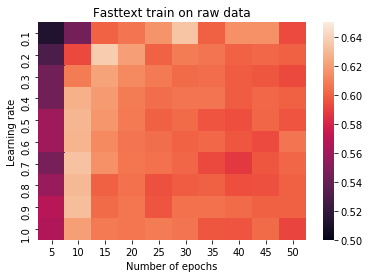

In [9]:
ax = seaborn.heatmap(result_raw, xticklabels=x_axis, yticklabels=y_axis, vmin=0.5, vmax=0.65)
ax.set_title('Fasttext train on raw data')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Learning rate')
for row in result_raw:
    print(row)

[0.6203208556149733, 0.6283422459893048, 0.6417112299465241, 0.6176470588235294, 0.5846702317290552, 0.6024955436720142, 0.5953654188948306, 0.5953654188948306, 0.5873440285204992, 0.5855614973262032]
[0.5721925133689839, 0.6345811051693405, 0.6016042780748663, 0.5900178253119429, 0.5793226381461675, 0.5766488413547237, 0.5793226381461675, 0.5766488413547237, 0.5784313725490197, 0.5757575757575757]
[0.5971479500891266, 0.6185383244206774, 0.5918003565062389, 0.5882352941176471, 0.5819964349376114, 0.5793226381461675, 0.5837789661319074, 0.5775401069518717, 0.5793226381461675, 0.5766488413547237]
[0.6060606060606061, 0.6024955436720143, 0.5953654188948306, 0.5855614973262032, 0.5775401069518716, 0.5793226381461675, 0.5748663101604278, 0.5784313725490197, 0.5802139037433155, 0.5828877005347594]
[0.6131907308377896, 0.6033868092691622, 0.5837789661319074, 0.5730837789661319, 0.5775401069518716, 0.5757575757575757, 0.5793226381461675, 0.5784313725490197, 0.5766488413547237, 0.5793226381461

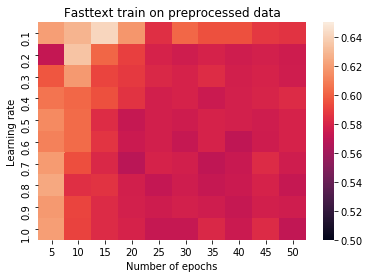

In [10]:
ax = seaborn.heatmap(result, xticklabels=x_axis, yticklabels=y_axis, vmin=0.5, vmax=0.65)
ax.set_title('Fasttext train on preprocessed data')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Learning rate')
for row in result:
    print(row)

In [8]:
fasttext_model = fasttext.train_supervised(input="ibc_fasttext.train", autotuneValidationFile="ibc_fasttext.val")
fasttext_model.test("ibc_fasttext.test")

(374, 0.5962566844919787, 0.5962566844919787)

In [10]:
fasttext_model.test_label("ibc_fasttext.test")

{'__label__CONSERVATIVE': {'precision': 0.6666666666666666,
  'recall': 0.23391812865497075,
  'f1score': 0.3463203463203463},
 '__label__LIBERAL': {'precision': 0.5828025477707006,
  'recall': 0.9014778325123153,
  'f1score': 0.7079303675048356}}

In [9]:
raw_fasttext_model = fasttext.train_supervised(input="raw_ibc_fasttext.train", autotuneValidationFile="raw_ibc_fasttext.val")
raw_fasttext_model.test("raw_ibc_fasttext.test")

(374, 0.5935828877005348, 0.5935828877005348)

In [11]:
raw_fasttext_model.test_label("ibc_fasttext.test")

{'__label__CONSERVATIVE': {'precision': 0.6019417475728155,
  'recall': 0.36257309941520466,
  'f1score': 0.45255474452554745},
 '__label__LIBERAL': {'precision': 0.5977859778597786,
  'recall': 0.7980295566502463,
  'f1score': 0.6835443037974683}}